In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import numpy as np

In [13]:
# Load the webscraped gas prices database
gas_df = pd.read_csv('../data/gas_prices.csv')
gas_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1993,NaN,NaN,NaN,1.078,1.100,1.097,1.078,1.062,1.050,1.092,1.066,1.014
1,1994,0.998,1.009,1.008,1.027,1.047,1.078,1.106,1.155,1.144,1.114,1.119,1.129
2,1995,1.130,1.120,1.119,1.157,1.225,1.239,1.201,1.170,1.158,1.134,1.109,1.118
3,1996,1.137,1.136,1.183,1.275,1.324,1.300,1.272,1.251,1.247,1.249,1.278,1.282
4,1997,1.283,1.276,1.251,1.244,1.245,1.242,1.220,1.268,1.276,1.242,1.216,1.177


In [14]:
# turn this data frame in to a time series with year and month as the index
# Melt the DataFrame
df_melted = gas_df.melt(id_vars=['Year'], var_name='Month', value_name='Price')

# Create a 'Date' column
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + df_melted['Month'], format='%Y%b')

# Drop redundant columns
gas_df_ts = df_melted.drop(['Year', 'Month'], axis=1)

# Sort the DataFrame
gas_df_ts = gas_df_ts.sort_values('Date')

# drop nans
gas_df_ts = gas_df_ts.dropna()

# set the index to the date
gas_df_ts = gas_df_ts.set_index('Date')

# Display the transformed DataFrame
print(gas_df_ts.head())

            Price
Date             
1993-04-01  1.078
1993-05-01  1.100
1993-06-01  1.097
1993-07-01  1.078
1993-08-01  1.062


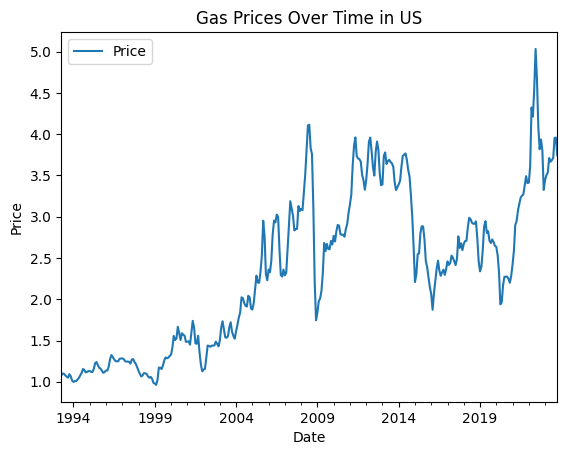

In [15]:
# plot the data with title and axis labels
gas_df_ts.plot()
plt.title('Gas Prices Over Time in US')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [33]:
# Connect to the database
conn = sqlite3.connect('../food_inflation_analysis.db')
# save data to the database
gas_df_ts.to_sql('gas_prices', conn, if_exists='replace')

# load the food inflation data
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
cpi_food_data.index = pd.to_datetime(cpi_food_data['Date'])
cpi_food_data = cpi_food_data.drop('Date', axis=1)
# Close the connection
conn.close()

In [42]:
# get the inflation data for the same time period as the gas prices
cpi_food_data = cpi_food_data[cpi_food_data.index >= gas_df_ts.index.min()]
gas_price_data = gas_df_ts[gas_df_ts.index <= cpi_food_data.index.max()]

# get the correlation between the two data sets
corr = gas_price_data['Price'].corr(cpi_food_data['Inflation'])
print('Correlation between gas prices and food inflation: ', corr)

lag = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in lag:
    corr = gas_price_data['Price'].shift(i).corr(cpi_food_data['Inflation'])
    print(f'Correlation between gas prices and food inflation with lag {i}: ', corr)
    # get the number of observations
    n = len(gas_price_data['Price'].shift(i))

    # get the t critical value
    t_crit = stats.t.ppf(0.975, n-2)

    # get the standard error
    se = np.sqrt((1-corr**2)/(n-2))

    # get the margin of error
    moe = t_crit*se

    # get the confidence interval
    ci = (corr-moe, corr+moe)
    print('Confidence interval for the correlation: ', ci)
    

Correlation between gas prices and food inflation:  0.23891879278491057
Correlation between gas prices and food inflation with lag 1:  0.2535692254490969
Confidence interval for the correlation:  (0.1526007029607643, 0.3545377479374294)
Correlation between gas prices and food inflation with lag 2:  0.26401422144330366
Confidence interval for the correlation:  (0.16333780158444927, 0.36469064130215806)
Correlation between gas prices and food inflation with lag 3:  0.26753056595083957
Confidence interval for the correlation:  (0.16695533338322488, 0.36810579851845426)
Correlation between gas prices and food inflation with lag 4:  0.26882405225714884
Confidence interval for the correlation:  (0.16828640413238868, 0.36936170038190896)
Correlation between gas prices and food inflation with lag 5:  0.2611125630153544
Confidence interval for the correlation:  (0.16035372761460953, 0.3618713984160993)
Correlation between gas prices and food inflation with lag 6:  0.24049290745310836
Confidence